# **IMPORTING ALL THE REQUIRED LIBRARIES**

In [ ]:
!pip install pmdarima
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATA PREPROCESSING

In [ ]:
#Data Preprocessing
df = pd.read_csv('/content/drive/MyDrive/SML_project/household_power_consumption.txt',sep=";", low_memory=False, na_values=['nan','?'])
df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)
#Storing Date and Time as one string in a new column 'TIME'
df['TIME'] = df['Date']+";"+df['Time']
df['TIME'] = pd.to_datetime(df['TIME'],format="%d/%m/%Y;%H:%M:%S")
df = df.drop(['Date', 'Time'],axis = 1).sort_values(by=['TIME'])
df['energy_consumed'] = (df['Global_active_power'] * 1000 / 60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,TIME,energy_consumed
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,52.266667
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,72.333333
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,70.566667
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,71.800000
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,43.100000
...,...,...,...,...,...,...,...,...,...
2075254,0.946,0.000,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00,15.766667
2075255,0.944,0.000,240.00,4.0,0.0,0.0,0.0,2010-11-26 20:59:00,15.733333
2075256,0.938,0.000,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00,15.633333
2075257,0.934,0.000,239.70,3.8,0.0,0.0,0.0,2010-11-26 21:01:00,15.566667


In [ ]:
#Handling NaN values using ffill command
df = df.fillna(method='ffill')
df = df.groupby(pd.Grouper(key='TIME',freq='SM')).sum()
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,energy_consumed
TIME,,,,,,,,
2006-12-15,38332.010,2739.412,4.965282e+06,161961.8,27536.0,48403.0,156485.0,406442.833333
2006-12-31,34634.820,3090.402,5.195859e+06,146674.4,19277.0,36935.0,144067.0,376968.000000
2007-01-15,35512.854,2797.424,5.558097e+06,150307.0,37156.0,36736.0,176994.0,340994.900000
2007-01-31,34341.684,2543.752,5.194277e+06,144951.6,29936.0,40371.0,172991.0,329063.400000
2007-02-15,23996.272,2110.592,4.500233e+06,101306.6,17648.0,29843.0,110396.0,242050.866667
...,...,...,...,...,...,...,...,...
2010-09-15,16098.902,2255.536,5.213235e+06,68185.6,15052.0,14313.0,116739.0,122211.033333
2010-09-30,25795.460,3010.278,5.202116e+06,108798.0,27538.0,21510.0,164309.0,216567.333333
2010-10-15,25911.786,3075.656,5.603286e+06,108544.4,19231.0,38835.0,153760.0,220037.100000


# **1. SEASONAL ARIMA**

## 1 a) Plotting Timeseries

No handles with labels found to put in legend.


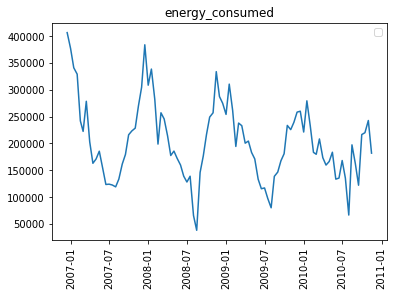

In [ ]:
plt.plot(df['energy_consumed'],linestyle = '-')
plt.xticks(rotation=90)
plt.title ('energy_consumed')
plt.legend()
plt.show()

### No noticeable trend observed. Seasonality is observed (every 12 months)


## 1 b) Running Dicki-fuller test on the dataset. If P value > 0.05 then timeseries is not stationery else it is stationery

In [ ]:
#ADF test function
def adf(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

#Calling the ADF test function on the target variable.
adf(df['energy_consumed'])

1. ADF :  -4.478756840257442
2. P-Value :  0.0002147697241848287
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression: 89
5. Critical Values :
	 1% :  -3.506057133647011
	 5% :  -2.8946066061911946
	 10% :  -2.5844100201994697


## 1 c) Time Series Decomposition

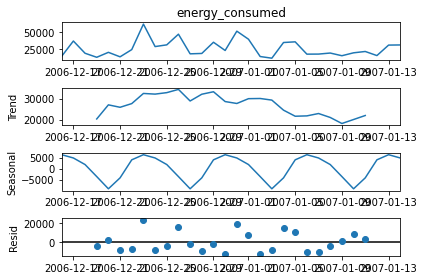

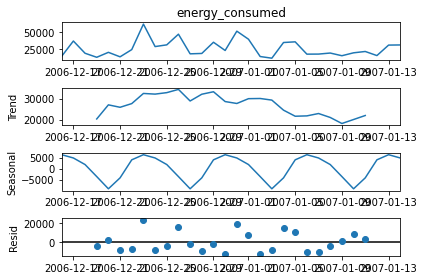

In [ ]:
components = seasonal_decompose(df['energy_consumed'][0:30], model='additive')
 
components.plot()

### P value <0.05 which suggests timeseries is stationary. However, we still observe some seasonality in the trend (By visual inspection and Time series Decomposition). Therefore we will use Seasonal ARIMA for this timeseries forecasting

# 1 d) Hyperparameter Tuning

##Determining values for P and Q in SARIMA

## Using ACF and PACF plots 


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


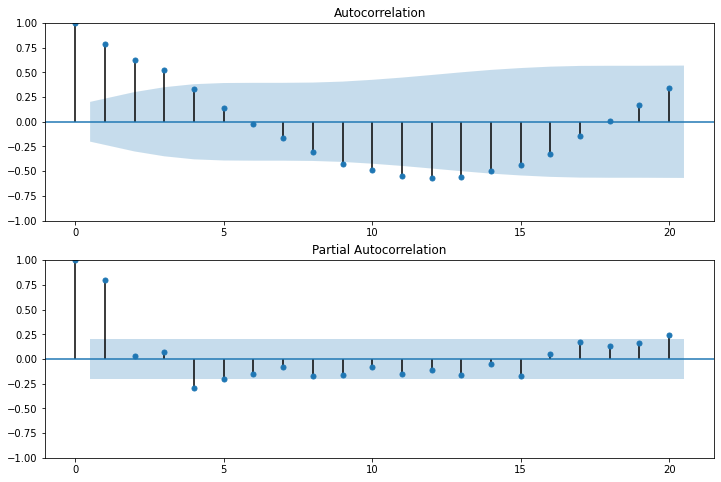

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(df['energy_consumed'],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(df['energy_consumed'],lags=20,ax=ax2)

### Here, we see 1 significant lag in PACF and 3 significant lags in ACF
### No differencing required
###So, 
### p=1  q=1 P=1 Q=1 d=0 and s=24 (Seasonality of 12 months but we have clubbed data semi-monthly so s=24)

# 1 f) TRAINING

In [ ]:
X = df['energy_consumed']

model = SARIMAX(X, order=(1,0,3),seasonal_order = (1,0,3,24))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


                                     SARIMAX Results                                      
Dep. Variable:                    energy_consumed   No. Observations:                   95
Model:             SARIMAX(1, 0, 3)x(1, 0, 3, 24)   Log Likelihood               -1133.054
Date:                            Wed, 15 Dec 2021   AIC                           2284.108
Time:                                    07:48:06   BIC                           2307.093
Sample:                                12-15-2006   HQIC                          2293.395
                                     - 11-15-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9649      0.020     48.958      0.000       0.926       1.003
ma.L1         -0.2100      0.133   

In [ ]:
# split into train and test sets
X = df['energy_consumed']#.values
size = int(len(X) * 0.7)
Test_size = len(X) - size
train, test = X[0:size], X[size:len(X)]



In [ ]:
#model = ARIMA(history, order=(1,0,0))
model = SARIMAX(train, order=(1,0,3),seasonal_order = (1,0,3,24))
model_fit = model.fit()
in_sample_forecast =model_fit.predict(start=2, end=size) #cut first value since it start value is 0
out_sample_forecast = model_fit.get_forecast(60, alpha = 0.4) #forecast on 100 period after

#in Data Plot
plt.plot(X[2:size])
plt.plot(in_sample_forecast, color='red',linestyle='dashed')
plt.show()

#Forecast Plot
plt.plot(X[2:len(X)])
plt.plot(out_sample_forecast.predicted_mean, color='red',linestyle='dashed')
#plt.plot(out_sample_forecast.conf_int()['lower Global_active_power'], color='green',linestyle='dashed')
#plt.plot(out_sample_forecast.conf_int()['upper Global_active_power'], color='green',linestyle='dashed')
plt.show()

### Testing model on Train Data

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


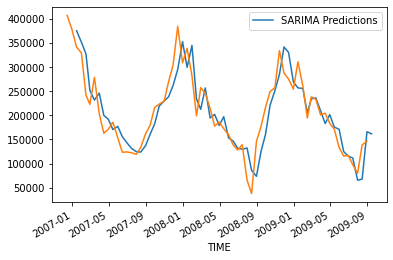

In [ ]:
model = SARIMAX(X, order=(1,0,3),seasonal_order = (1,0,3,24))
model=model.fit()
model.summary()
start=0
end=len(train)
pred=model.predict(start=start+2,end=end).rename('SARIMA Predictions')
pred.plot(legend=True)
df['energy_consumed'][0:len(train)].plot()

### Testing model on Test data

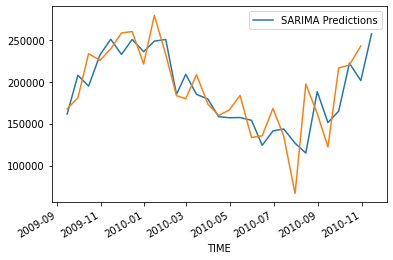

In [ ]:
pred=model.predict(start=len(train),end=len(train)+len(test)-1).rename('SARIMA Predictions')
pred.plot(legend=True)
df['energy_consumed'][len(train):len(train)+len(test)-1].plot()

### Forecasting for the next 24 time periods

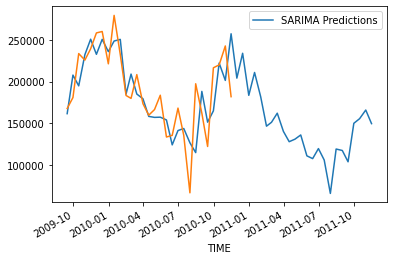

In [ ]:
pred=model.predict(start=len(train),end=len(train)+len(test)-1+24).rename('SARIMA Predictions')
pred.plot(legend=True)
df['energy_consumed'][len(train):len(train)+len(test)-1+24].plot()

### Metric Evaluation

In [ ]:
pred=model.predict(start=len(train),end=len(train)+len(test)-1)
rmse=np.sqrt(mean_squared_error(pred,df['energy_consumed'][len(train):len(train)+len(test)]))
r2=r2_score(pred,df['energy_consumed'][len(train):len(train)+len(test)])
mae=mean_absolute_error(df['energy_consumed'][len(train):len(train)+len(test)],pred)
mape=mean_absolute_percentage_error(df['energy_consumed'][len(train):len(train)+len(test)],pred)

In [ ]:
len(df['energy_consumed'][len(train):])

29

In [ ]:
rmse,r2,mae,mape

(32290.084403033503,
 0.4258682170238981,
 24854.46493495043,
 0.15006797004397238)

# 2 LINEAR REGRESSION AND RANDOM FORESTS

##2 a) Converting time series into supervised machine learning problem

In [ ]:
#Function create differencing and adding new columns to dataset
def to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
#modified dataset
data_reframed = to_supervised(df, 1, 1)
data_reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
TIME,,,,,,,,,,,,,,,,
2006-12-31,38332.010,2739.412,4.965282e+06,161961.8,27536.0,48403.0,156485.0,406442.833333,34634.820,3090.402,5.195859e+06,146674.4,19277.0,36935.0,144067.0,376968.000000
2007-01-15,34634.820,3090.402,5.195859e+06,146674.4,19277.0,36935.0,144067.0,376968.000000,35512.854,2797.424,5.558097e+06,150307.0,37156.0,36736.0,176994.0,340994.900000
2007-01-31,35512.854,2797.424,5.558097e+06,150307.0,37156.0,36736.0,176994.0,340994.900000,34341.684,2543.752,5.194277e+06,144951.6,29936.0,40371.0,172991.0,329063.400000
2007-02-15,34341.684,2543.752,5.194277e+06,144951.6,29936.0,40371.0,172991.0,329063.400000,23996.272,2110.592,4.500233e+06,101306.6,17648.0,29843.0,110396.0,242050.866667
2007-02-28,23996.272,2110.592,4.500233e+06,101306.6,17648.0,29843.0,110396.0,242050.866667,24590.154,2344.192,5.198877e+06,104019.8,26730.0,48416.0,112214.0,222475.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-09-15,21091.952,2784.726,5.211482e+06,90072.0,23912.0,19147.0,146329.0,162144.533333,16098.902,2255.536,5.213235e+06,68185.6,15052.0,14313.0,116739.0,122211.033333
2010-09-30,16098.902,2255.536,5.213235e+06,68185.6,15052.0,14313.0,116739.0,122211.033333,25795.460,3010.278,5.202116e+06,108798.0,27538.0,21510.0,164309.0,216567.333333
2010-10-15,25795.460,3010.278,5.202116e+06,108798.0,27538.0,21510.0,164309.0,216567.333333,25911.786,3075.656,5.603286e+06,108544.4,19231.0,38835.0,153760.0,220037.100000


In [ ]:
X=data_reframed.iloc[:,:-1].values
Y=data_reframed.iloc[:,-1].values

In [ ]:
X_train,X_test,y_train,y_test=X[:-20],X[-20:],Y[:-20],Y[-20:]

## 2 b)Fitting Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression 

In [ ]:
model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)

LinearRegression()

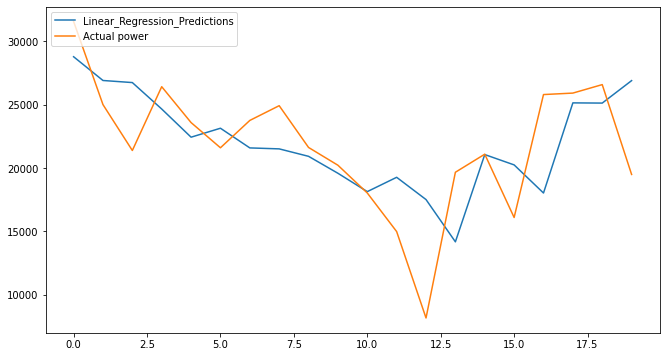

In [ ]:
lin_pred=lin_model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(lin_pred,label='Linear_Regression_Predictions')
plt.plot(y_test,label='Actual power')
plt.legend(loc="upper left")
plt.show()

In [ ]:
#Linear Regression
rmse=np.sqrt(mean_squared_error(lin_pred,y_test))
r2=r2_score(y_test,lin_pred)
mae=mean_absolute_error(y_test,lin_pred)
mape=mean_absolute_percentage_error(y_test,lin_pred)
rmse,r2,mae,mape

(4091.3682512588325, 0.318469450899739, 3109.7340061931272, 0.1815639101237096)

## 2 c)Hyperparameter Tuning for Linear Regression:
 1. Ridge Regression
 2. Lasso Regression

In [ ]:

alpha_list=[0.1,0.01,0.001]

for i in alpha_list:
  ridge_model = Ridge(alpha=i)
  ridge_model.fit(X_train, y_train)
  pred1=ridge_model.predict(X_test)
  rmse_rr=np.sqrt(mean_squared_error(pred1,y_test))
  r2_1=r2_score(pred1,y_test)
  mae1=mean_absolute_error(y_test,pred1)
  mape1=mean_absolute_percentage_error(y_test,pred1)
  print("Ridge Regression : RMSE, R2, MAE and MAPE for alpha={}".format(i))
  print(rmse_rr,r2_1,mae1,mape1)
  print("\n")
  
print("\n\n\n")
for i in alpha_list:
  Lasso_model = Lasso(alpha=i)
  Lasso_model.fit(X_train,y_train)
  pred2=Lasso_model.predict(X_test)
  rmse_lar=np.sqrt(mean_squared_error(pred2,y_test))
  r2_2=r2_score(pred2,y_test)
  mae2=mean_absolute_error(y_test,pred2)
  mape2=mean_absolute_percentage_error(y_test,pred2)
  print("Lasso Regression : RMSE, R2, MAE and MAPE for alpha={}".format(i))
  print(rmse_lar,r2_2,mae2,mape2)
  print("\n")
  

Ridge Regression : RMSE, R2, MAE and MAPE for alpha=0.1
3988.8132376004583 -0.29120485185134015 3080.635287265794 0.18055978123431232


Ridge Regression : RMSE, R2, MAE and MAPE for alpha=0.01
3988.813238373257 -0.29120485223555126 3080.6352874584786 0.18055978126180833


Ridge Regression : RMSE, R2, MAE and MAPE for alpha=0.001
3988.8132384505225 -0.2912048522739852 3080.635287477745 0.1805597812645571






Lasso Regression : RMSE, R2, MAE and MAPE for alpha=0.1
3971.2301241184923 -0.2703657332657834 3108.9182329526666 0.18057894854814185


Lasso Regression : RMSE, R2, MAE and MAPE for alpha=0.01
3971.2300424395967 -0.2703656639836327 3108.918197580143 0.18057894506196165


Lasso Regression : RMSE, R2, MAE and MAPE for alpha=0.001
3971.2300342717103 -0.27036565705543003 3108.9181940428934 0.18057894471334376




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.799e+08, tolerance: 3.390e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.799e+08, tolerance: 3.390e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)
model.fit(X_train,y_train)



RandomForestRegressor(max_features=3, random_state=1)

### 2 d) Random Forests

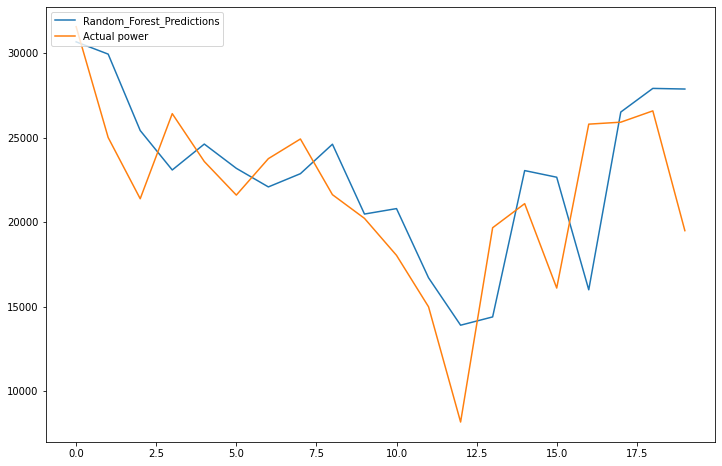

In [ ]:
pred=model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual power')
plt.legend(loc="upper left")
plt.show()

In [ ]:
#Random Forest
rmse=np.sqrt(mean_squared_error(pred,y_test))
r2=r2_score(y_test,pred)
mae=mean_absolute_error(y_test,pred)
mape=mean_absolute_percentage_error(y_test,pred)
rmse,r2,mae,mape

(4233.930088562689,
 0.2701467416440386,
 3344.4474529999825,
 0.17906410995650426)

## Hyperparameter Tuning for Random Forests
###n=200,300,400,500
###max_features=2,4,8

In [ ]:
n_list=[200,300,400,500]
features=[2,4,8]

for i in n_list:
  for j in features:
    model1=RandomForestRegressor(n_estimators=i,max_features=j, random_state=1)
    model1.fit(X_train,y_train)
    pred3=model.predict(X_test)
    rmse3=np.sqrt(mean_squared_error(pred3,y_test))
    r23=r2_score(y_test,pred3)
    mae3=mean_absolute_error(y_test,pred3)
    mape3=mean_absolute_percentage_error(y_test,pred3)
    print("Random Forest with n={} and max features={} has the following metrics:\n".format(i,j))
    print("RMSE, R2,MAE, and MAPE :",rmse3,r23,mae3,mape3)
    print("\n")





Random Forest with n=200 and max features=2 has the following metrics:

RMSE, R2,MAE, and MAPE : 4233.930088562689 0.2701467416440386 3344.4474529999825 0.17906410995650426


Random Forest with n=200 and max features=4 has the following metrics:

RMSE, R2,MAE, and MAPE : 4233.930088562689 0.2701467416440386 3344.4474529999825 0.17906410995650426


Random Forest with n=200 and max features=8 has the following metrics:

RMSE, R2,MAE, and MAPE : 4233.930088562689 0.2701467416440386 3344.4474529999825 0.17906410995650426


Random Forest with n=300 and max features=2 has the following metrics:

RMSE, R2,MAE, and MAPE : 4233.930088562689 0.2701467416440386 3344.4474529999825 0.17906410995650426


Random Forest with n=300 and max features=4 has the following metrics:

RMSE, R2,MAE, and MAPE : 4233.930088562689 0.2701467416440386 3344.4474529999825 0.17906410995650426


Random Forest with n=300 and max features=8 has the following metrics:

RMSE, R2,MAE, and MAPE : 4233.930088562689 0.27014674